In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image
import torchvision.models
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms 
import torch.utils.data as data
import torchvision.utils
from torchsummary import summary
import torch.optim as optim
from torch.optim import lr_scheduler
import time

In [2]:
## Enter number of CPUs requested from Sherlock. Down the line figure out GPUs. 
num_workers = 32

## Build Custom Dataset

All data is in the path '/scratch/groups/earlew/arlenlex/cs230-dataset/'. This directory has the following structure:

```
cs230-datasetv2
|
|_ train
|___ x_train
|___ y_train
|
|_ test
|___ x_test
|___ y_test
```

We want to build a dataloader for the training and testing datasets. Our images in these folders are all .npy files with shape 320x512. We include a preprocessing step in which we artifically add channels for each photo. Because our model is trained with a resnet18 backbone, we need to create three color channels for our input and one for our output. Thus, we use augment our data such that:

```
input_size = [3, 320, 512]

output_size = [1, 320, 512]
```

In [3]:
class DatasetTrain(data.Dataset):
    def __init__(self, folder_path):
        super(DatasetTrain, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'x_trainb','*.npy')))
        self.mask_files = sorted(glob.glob(os.path.join(folder_path,'y_trainb','*.npy')))
        
    def __getitem__(self, index):
        #images
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = np.load(img_path, allow_pickle=True)
        image = torch.from_numpy(image).float()
        image = image.permute(2,0,1)
        
        #masks
        mask_path = self.mask_files[index]
        mask = np.load(mask_path, allow_pickle=True)
        mask = torch.from_numpy(mask).float()
        mask = mask[None, :, :].expand([1, 640, 896])
        return image, mask

    def __len__(self):
        return len(self.img_files)

In [4]:
class DatasetTest(data.Dataset):
    def __init__(self, folder_path):
        super(DatasetTest, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path,'x_testb','*.npy')))
        self.mask_files = sorted(glob.glob(os.path.join(folder_path,'y_testb','*.npy')))

    def __getitem__(self, index):
        #images
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        image = np.load(img_path, allow_pickle=True)
        image = torch.from_numpy(image).float()
        image = image.permute(2,0,1)
        
        #masks
        mask_path = self.mask_files[index]
        mask = np.load(mask_path, allow_pickle=True)
        mask = torch.from_numpy(mask).float()
        mask = mask[None, :, :].expand([1, 640, 896])
        return image, mask

    def __len__(self):
        return len(self.img_files)

## Load data

In [82]:
train_ds = DatasetTrain('/scratch/groups/earlew/arlenlex/cs230-datasetv2/train/')
test_ds = DatasetTest('/scratch/groups/earlew/arlenlex/cs230-datasetv2/test/')
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=num_workers)
dataloaders = {'train': train_loader, 'val' : test_loader}

## Data visualization

In [83]:
def plot2x2Array(image, mask):
    fig, axs = plt.subplots(1,2)
    ax = axs.flatten()
    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(mask, cmap ='gray', vmin=0, vmax=1)
    ax[0].set_title('Image')
    ax[1].set_title('Mask')

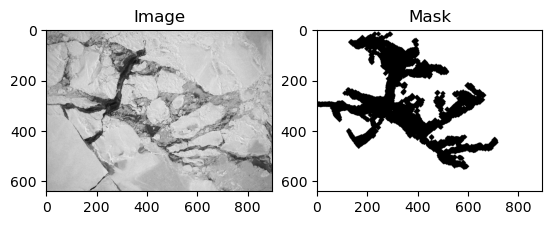

In [84]:
idx = torch.randint(high = len(train_ds), size = (1,))
image, mask = train_ds[idx]
plot2x2Array(image[0,:,:], mask[0,:,:])

## Define the model.

Here, we define a simple U-Net with three downsampling layers, three upsampling layers, and skip connections between the lowest two upsampling and downsampling layers. For all layers, RELU acitvation functions are used. The model we use was found in this [github repository](https://github.com/usuyama/pytorch-unet). We chose this model as the authors used it for binary segmetnation of aerial imagery of clouds. For further work, we will experiment with different architectures and consider using a pretrained backbone. 

In [85]:
def convrelu(in_channels, out_channels, kernel, padding):
      return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
        )


class ResNetIceNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = torchvision.models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)
        #self.conv_last_fr = nn.one

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [86]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   


class IceNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
                
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)        

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

## Instantiate the model

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda


In [88]:
summary(model, input_size=(3, 640, 896));

Layer (type:depth-idx)                   Param #
├─ResNet: 1-1                            --
|    └─Conv2d: 2-1                       (9,408)
|    └─BatchNorm2d: 2-2                  (128)
|    └─ReLU: 2-3                         --
|    └─MaxPool2d: 2-4                    --
|    └─Sequential: 2-5                   --
|    |    └─BasicBlock: 3-1              (73,984)
|    |    └─BasicBlock: 3-2              (73,984)
|    └─Sequential: 2-6                   --
|    |    └─BasicBlock: 3-3              (230,144)
|    |    └─BasicBlock: 3-4              (295,424)
|    └─Sequential: 2-7                   --
|    |    └─BasicBlock: 3-5              (919,040)
|    |    └─BasicBlock: 3-6              (1,180,672)
|    └─Sequential: 2-8                   --
|    |    └─BasicBlock: 3-7              (3,673,088)
|    |    └─BasicBlock: 3-8              (4,720,640)
|    └─AdaptiveAvgPool2d: 2-9            --
|    └─Linear: 2-10                      (513,000)
├─Sequential: 1-2                       

## Train the model. 

First, we define the loss function.

In [89]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()

Now, we define the main training loop. 

In [90]:
from collections import defaultdict
import torch.nn.functional as F

checkpoint_path = "checkpoint1.pth"

def calc_loss(pred, target, metrics, bce_weight=0.7):
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10
    L = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]: 
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)
                    L.append(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model, L

Train the model. 

In [91]:
num_class = 1
model = ResNetIceNet(num_class).to(device)
model.train()

# freeze backbone layers
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay = 1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

model, L = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.38 GiB (GPU 0; 79.19 GiB total capacity; 73.93 GiB already allocated; 985.62 MiB free; 76.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

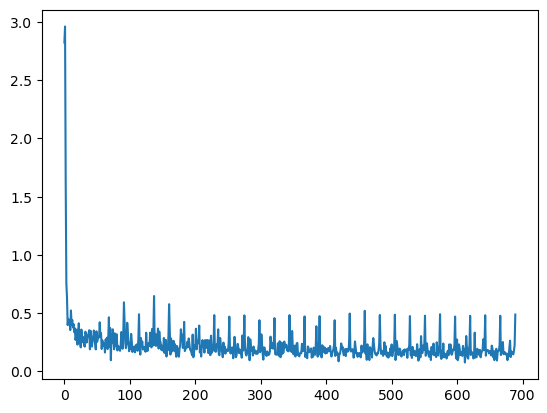

In [55]:
loss = torch.tensor(L, device = 'cpu')
loss = loss.detach().numpy()
plt.plot(loss)

# Model Evaluation
First, we load in some HOTRAX photos to evaluate our model. 

In [56]:
class DatasetEval(data.Dataset):
    def __init__(self, folder_path):
        super(DatasetEval, self).__init__()
        self.img_files = sorted(glob.glob(os.path.join(folder_path, 'eval', '*.JPG')))
    def __getitem__(self, index):
        #images
        img_path = self.img_files[index]
        image = Image.open(img_path)
        MAX_SIZE = (1000, 1000)
        image.thumbnail(MAX_SIZE)
        image = np.array(image)
        image = image[0:640, 0:896, :]
        image = torch.from_numpy(image).float()
        image = image.permute(2,0,1)
        return image
    def __len__(self):
        return len(self.img_files)

In [57]:
def postprocessing(pred):
    #pred = torch.sigmoid(pred)
    pred = pred.to('cpu')
    pred = pred.detach().numpy()
    pred[pred <= 0.5] = 0
    pred[pred > 0.5] = 1
    return pred

In [58]:
model.eval();

In [62]:
model_eval_ds = DatasetEval('/scratch/groups/earlew/arlenlex/cs230-datasetv2/')
model_eval_loader = DataLoader(model_eval_ds, batch_size = 1, shuffle = True, num_workers = 32)

Make the prediction

In [63]:
inputs = next(iter(model_eval_loader))
inputs = inputs.to(device)
pred = model(inputs)
inputs = inputs.to("cpu")
pred = postprocessing(pred)

Visualize the prediction

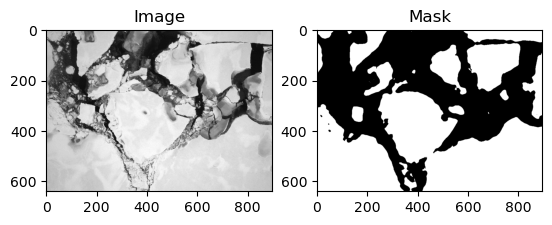

In [64]:
fig, axs = plt.subplots(1,2)
ax = axs.flatten()
ax[0].imshow(inputs[0,0,:,:], cmap='gray')
ax[0].set_title('Image')
ax[1].set_title('Mask')
ax[1].imshow(pred[0,0,:,:], cmap='gray')